In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Table of Contest

0. Collect & Clean Data
1. Initial Modeling & Predictions

## 0. Collect & Clean Data

Based on preliminary analysis it appears that the submission would include predictions equated to the `test.csv` data, and a model should be built on the `train.csv` data. Based on description from competition, the `gender_submission.csv` describes how the submission csv should look.

In [2]:
# Collecting the data
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
len(titanic_train)

891

In [3]:
# Check the btype of the columns
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Based on the dtypes of the training data we should be able to make some quick decisions about how to handle the data.

1. Name can be removed (we do not need to train any model on the name of the passenger)
2. PassengerId should also be removed as they are unique and not indicative of a pattern
3. Columns that are of dtype int64 or float64 should be fine to analyze
4. We could use `OneHotEncoder` and `ColumnTransformer` to convert the object values into numbers

We can find a proper model to use using the [sklearn machine learning map](https://scikit-learn.org/1.5/machine_learning_map.html). Since we have training data that contains 891 rows, we're looking to make a classification, and have labeled data our first model we use should be `Linear SVC`. Since the map recommends `LinearSVC`, we know that the model doesn't work with `NaN` values, so we need to check to see if null values exist in this data set.

In [4]:
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Because there are so many null values in very specific columns, (one column is an object while the other is numeric) it might be better to go with a different estimator at first. I've ran some code ahead of this and was provided a warning that `LinearSVC` doesn't accept `NaN` values. This should be dealt with in the pipeline using an `imputer` function.

Next item, there were unknown columns found during fitting, and so I would like to look into some of the columns to see if I can identify where these are coming from.

In [5]:
titanic_train['Ticket'].head(n=50).unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237'], dtype=object)

In [6]:
len(titanic_train['Ticket']), len(titanic_train['Ticket'].unique())

(891, 681)

The `Ticket` values appear to be very inconsistent and might make our models chock without adding any additional value. There might be some inherent information that is beneficial to determining whether a person died or not, if so it might have something to do with the duplicate values, but as of our initial validation and modeling we should probably ignore them. The same could be said for unique 

In [7]:
titanic_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [8]:
len(titanic_train['Cabin']),len(titanic_train['Cabin'].unique())

(891, 148)

the `Cabin` column has values that are highly unique like the `Ticket` values, but are much more consistent and may actually have some barring on whether someone survives or not (certain cabins may have a higher liklihood or death based on how the titanic sunk as an example). This can be done by separating the cabin values into their categorical alphabetic value and their numeric number value. This should be done using a function so that it can be done easily to the test data once training is complete

In [9]:
# function to clean the dataset. Will be expanded on as more cleaning is needed
def clean_df(df):
    
    # Split the Cabin values into a A-Z and 0-9 columns
    df['Cabin_ABC'] = df['Cabin'].str.extract(r'([A-Za-z]+)',expand=False)
    df['Cabin_Num'] = df['Cabin'].str.extract(r'(\d+)',expand=False).astype('Float64')
    
    return df

In [10]:
# Clean the dataframe before going onto the next step
titanic_clean = clean_df(titanic_train)

## 1. Initial Modeling & Hyperparameters

### 1.1 Creating a data pipeline & making initial validations

A good way to tackle this would be to make a pipeline that we can use whenever we want to fig data. If we determine we need to use a different model we can adjust it later.

In [11]:
# import the modules that we will be using for the next couple of stages
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import svm

In [12]:
# Organize the categorial and numerical columns
categorical_features = ['Sex','Embarked']
numerical_features = ['Cabin_Num','Pclass','Age','SibSp','Parch','Fare']

# Create the preprocessor using OneHotEncoder and ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(),categorical_features),
        ('num',SimpleImputer(strategy='mean'),numerical_features)
    ])

# Add the LinearSVC model to the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',svm.SVC())
])

Next we could make a function to evaluate the predictions that are generated in the initial validation period before the training is to occur. As a note, we are going to split the training material into three parts (training,validation, and testing). This will breakdown into 70:15:15 ratios. The goal is to use the 15% validation set to help determine how best to tweak the hyperparameters, then using the test set on the training set once fitting has occurred. We will do this by making a function to spit out the metric scores of the initial validation, but if more improvements need to be made we should have room for that. I'm going to be doing this by taking all metrics of a specific validated model (a metric dictionary) and adding it to a larger universal dictionary for plotting comparisons later.

In [13]:
# import additional modules
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# initialize the validation dictionary
metric_valid_dict = {}

In [14]:
# Function to take the true and predicted values and provide scoring
def evaluate_preds(true,preds):
    """
    Performs evalution comparisons on y_true values vs. y_pred values on a classification.
    """
    
    # create a dictionary of scoring values
    metric_dict = {
        'accuracy':round(accuracy_score(true,preds),2),
        'precision':round(precision_score(true,preds),2),
        'recall':round(recall_score(true,preds),2),
        'f1':round(f1_score(true,preds),2)
    }
    
    # print the calculated metrics
    for item in metric_dict:
        if item == 'accuracy':
            print(f'{item}: {metric_dict[item]*100:.2f}%')
        else:
            print(f'{item}: {metric_dict[item]:.2f}')
    
    return metric_dict

In [15]:
# Split the data into train,validation,test sets at a rate of (70:15:15)
titanic_shuffled = titanic_train.sample(frac=1)
X = titanic_shuffled.drop('Survived',axis=1)
y = titanic_shuffled['Survived']
train_split = round(0.7 * len(titanic_shuffled))
valid_split = round(train_split + 0.15 * len(titanic_shuffled))
X_train,y_train = X[:train_split],y[:train_split]
X_valid,y_valid = X[train_split:valid_split],y[train_split:valid_split]
X_test,y_test = X[valid_split:],y[valid_split:]

In [16]:
# Instantiate the chosen model for later analysis
model_pipeline.fit(X_train,y_train)

# Make baseline predictions
y_preds = model_pipeline.predict(X_valid)

# Evaluate the classifier on validation set
metric_valid_dict.update({'baseline':evaluate_preds(y_valid,y_preds)})

accuracy: 72.00%
precision: 0.56
recall: 0.46
f1: 0.51


Despite this being a success, it is also a really low score which shows how necessary it is now to start Validating and hypertuning

## 2. Hypertuning & Metric Scoring

Because of the complications that have arisen due to additional resources needed, I will try shifting from a sci-kit learn framework to a tensorflow framework.

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
def preprocess_data(data,categorical_features=['Sex','Embarked'],numerical_features=['Cabin_Num','Pclass','Age','SibSp','Parch','Fare']):

    # Create the preprocessor using OneHotEncoder and ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat',OneHotEncoder(),categorical_features),
            ('num',Pipeline(steps=[
                ('imputer',SimpleImputer(strategy='mean')),
                ('scaler',StandardScaler())
            ]),numerical_features)
        ])

    # transform the X_train into a csr matrix to pass into a new tensorflow workflow
    return preprocessor

In [19]:
# Define columns to keep in the preprocessor
categorical_features=['Sex','Embarked']
numerical_features=['Cabin_Num','Pclass','Age','SibSp','Parch','Fare']

# Create the preprocessor using OneHotEncoder and ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(),categorical_features),
        ('num',Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='mean')),
            ('scaler',StandardScaler())
        ]),numerical_features)
    ])

# Fit the preprocessor to all the cleaned data
preprocessor.fit_transform(titanic_clean)

# Transform X_train and X_test on the fit transformation
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
X_valid_preprocessed = preprocessor.transform(X_valid)

# Check the chapes
X_train_preprocessed.shape,X_test_preprocessed.shape,X_valid_preprocessed.shape

((624, 12), (133, 12), (134, 12))

Next we need to import the tensorflow libraries and begin building the new framework

In [20]:
import tensorflow as tf
from tensorflow.keras import layers,models,regularizers

Next we should build a function to help build a model using tensorflow so we can make the building model process more customizable as we progress

In [21]:
# Function with fiddly knobs that can be used to generate a tensorflow model and make improvements overtime
def build_model(
    input_shape,num_layers=2,units_per_layer=[128,64],
    activation='relu',dropout_rate=0.5,
    regularization=None,learning_rate=0.001):
    
    # Initialize the model
    model = models.Sequential()
    
    # Generate the input layer
    model.add(layers.Dense(units_per_layer[0],activation=activation,
                           input_shape=(input_shape,),
                           kernel_regularizer=regularizers.l2(regularization) if regularization else None))
    
    # Optional dropout after the first layer
    if dropout_rate:
        model.add(layers.Dropout(dropout_rate))
    
    # Add hidden layers dynamically based on the num_layers and units_per_layer
    for i in range(1,num_layers):
        model.add(layers.Dense(units_per_layer[i],activation=activation,
                               kernel_regularizer=regularizers.l2(regularization) if regularization else None))
        if dropout_rate:
            model.add(layers.Dropout(dropout_rate))
    
    # Output Layer (binary classification with sigmoid)
    model.add(layers.Dense(1,activation='sigmoid'))
    
    # Compile the model with the provided learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',metrics=['accuracy','Precision','Recall'])
    
    return model

In [22]:
# Generate the model
model = build_model(
    input_shape=X_train_preprocessed.shape[1],
    learning_rate=0.001
)

# Fit the model
model.fit(X_train_preprocessed,y_train,epochs=10,batch_size=32)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1729203838.935217      69 service.cc:145] XLA service 0x7bf6bc003b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729203838.935282      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729203838.935286      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - Precision: 0.2778 - Recall: 0.5556 - accuracy: 0.4688 - loss: 0.8061

I0000 00:00:1729203843.085941      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - Precision: 0.3998 - Recall: 0.3815 - accuracy: 0.5427 - loss: 0.7132
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6084 - Recall: 0.3821 - accuracy: 0.6583 - loss: 0.6181 
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.7758 - Recall: 0.4591 - accuracy: 0.7208 - loss: 0.5727 
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.7732 - Recall: 0.5303 - accuracy: 0.7499 - loss: 0.5163 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.7576 - Recall: 0.6154 - accuracy: 0.7791 - loss: 0.4738 
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.7587 - Recall: 0.6640 - accuracy: 0.7736 - loss: 0.4988 
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8388 - Recall: 0.7689 - accuracy: 0.8454 - loss: 0.4352 
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8011 - Recall: 0.7696 - accuracy: 0.8285 - loss: 0.4422 
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━

In [23]:
# Evaluate the model
_,test_acc,_,_ = model.evaluate(X_valid_preprocessed,y_valid)

# Spit out the results
print(f'Test Accuracy: {test_acc * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - Precision: 0.8074 - Recall: 0.6600 - accuracy: 0.8509 - loss: 0.3905
Test Accuracy: 85.07%


In [24]:
# Create a prediction and convert it into values similar to SciKit-Learn
y_preds = model.predict(X_valid_preprocessed)
y_preds = (y_preds > 0.5).astype("int32")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [25]:
y_preds.shape,y_valid.shape

((134, 1), (134,))

In [26]:
# Evaluate and score the model
metric_valid_dict.update({'tensorflow baseline':evaluate_preds(y_valid,y_preds)})

accuracy: 85.00%
precision: 0.80
recall: 0.68
f1: 0.74


The above scoring shows that there was an improvement in metrics transitioning from the `LinearSVC` model from the scikit-learn libraries to a framework focusing on `TensorFlow`. The next step would be to improve the model. The goal is to get above 80%, but also get as asymptotically close to 100% as possible.

Next, I would like to see if I can make a block of code that tests a number of settings to fiddle with to come with the best metrics. This block of code will be adjusted over time, and my hope (if needed) is that this block of code turns into a function that can have it's own fiddley knobs to come to a better fit model.

In [27]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 2


In [28]:
from sklearn.model_selection import KFold

In [29]:
# Initialize values
best_model = None
best_accuracy = 0
kfold = KFold(n_splits=5,shuffle=True)
input_shape = X_train_preprocessed.shape[1]

# Create embedded for loops with the metrics to fiddle with
for units in [[128,64],[256,128,64],[512,256,128]]:
    for dropout in [0.3, 0.5]:
        for lr in [0.001,0.0005]:
            for batch_size in [32,64]:
                model = build_model(input_shape=input_shape,
                                   num_layers=len(units),
                                             units_per_layer=units,
                                             dropout_rate=dropout,
                                             learning_rate=lr)
                
                # Train the model with the current hyperparameters
                history = model.fit(X_train_preprocessed,y_train,epochs=10,batch_size=batch_size,
                                   validation_data=(X_valid_preprocessed,y_valid),verbose=0)
                
                # Evaluate validation accuracy
                val_acc = history.history['val_accuracy'][-1]
                
                # Keep track of the best model
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_model = model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
print(f'{best_accuracy*100:.2f}%')

85.82%


### 2.1 Final Predictions

In [31]:
X_train_preprocessed.shape,X_valid_preprocessed.shape,y_train.shape,y_valid.shape

((624, 12), (134, 12), (624,), (134,))

In [32]:
# Combine both the training and the validation sets
X_train_final = np.concatenate((X_train_preprocessed,X_valid_preprocessed),axis=0)
y_train_final = np.concatenate((y_train,y_valid),axis=0)

In [33]:
X_train_final.shape,y_train_final.shape

((758, 12), (758,))

In [34]:
# Train a model use the fully trained data
best_model.fit(X_train_final,y_train_final.reshape(-1,1),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - Precision: 0.8407 - Recall: 0.7552 - accuracy: 0.8561 - loss: 0.3662
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8579 - Recall: 0.7278 - accuracy: 0.8466 - loss: 0.3646 
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.9014 - Recall: 0.7084 - accuracy: 0.8568 - loss: 0.3582 
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8729 - Recall: 0.7352 - accuracy: 0.8596 - loss: 0.3489 
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8368 - Recall: 0.7171 - accuracy: 0.8520 - loss: 0.3457 
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8555 - Recall: 0.7755 - accuracy: 0.8622 - loss: 0.3445 
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8934 - Recall: 0.7270 - accuracy: 0.8647 - loss: 0.3394 
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.8703 - Recall: 0.7349 - accuracy: 0.8559 - loss: 0.3724 
Epoch 9/10
12/12 ━━━━━━

In [35]:
predictions_test = best_model.predict(X_test_preprocessed)
predictions_to_binary = (predictions_test > 0.5).astype('int32')
metric_valid_dict.update({'final':evaluate_preds(y_test,predictions_to_binary)})

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
accuracy: 75.00%
precision: 0.76
recall: 0.55
f1: 0.64


<Axes: >

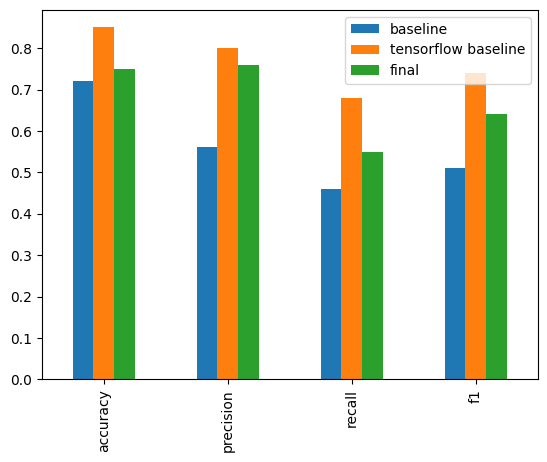

In [36]:
pd.DataFrame(metric_valid_dict).plot.bar()

## X. Predict Survivors & Make Submission

In [37]:
# Read the test data
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Clean, Process, and Make predicitions using generated model
Predictions = best_model.predict(preprocessor.transform(clean_df(test_data)))
Predictions_binary = (Predictions > 0.5).astype('int32')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [38]:
# Build the submission dataframe
submission = pd.DataFrame({
    'PassengerId':test_data['PassengerId'],
    'Survived':Predictions_binary.flatten()
})

In [39]:
submission.to_csv('titanic_submission.csv',index=False)